In [1]:
import sys, os ; sys.path.append(os.path.join('..', 'src'))
import torch
import torch.nn as nn

import pytorch_lightning as pl

from dynamics_control.learners import DynamicsControlLearner

# from dynamics_control.utils import prior_dist, target_dist
from dynamics_control.trainer import prior, target, aug_f, t_span
from numpy import pi as pi

## Load checkpoint

In [2]:
ckpt_path = os.path.join(
    '..',
    'dynamics-control-learner',
    '2omjkf8k',
    'checkpoints',
    'epoch=999-step=999.ckpt'
)
learner = DynamicsControlLearner.load_from_checkpoint(
    ckpt_path, 
    model=aug_f, 
    prior_dist=prior, 
    target_dist=target, 
    t_span=t_span
)

In [8]:
from torchdiffeq import odeint
n_ic = 256
x0 = prior.sample(torch.Size([n_ic])).cpu()
x0 = torch.cat([x0, torch.zeros(n_ic, 1)], 1)
traj_true_system = odeint(learner.model, x0, t_span, method='midpoint').detach()
traj_pred_system = odeint(learner.model.f.parametrized_forward, x0[:, 0:2], t_span, method='midpoint').detach()

In [9]:
traj_true_system.shape

torch.Size([30, 256, 3])

In [10]:
traj_pred_system.shape

torch.Size([30, 256, 2])

## Plot Result

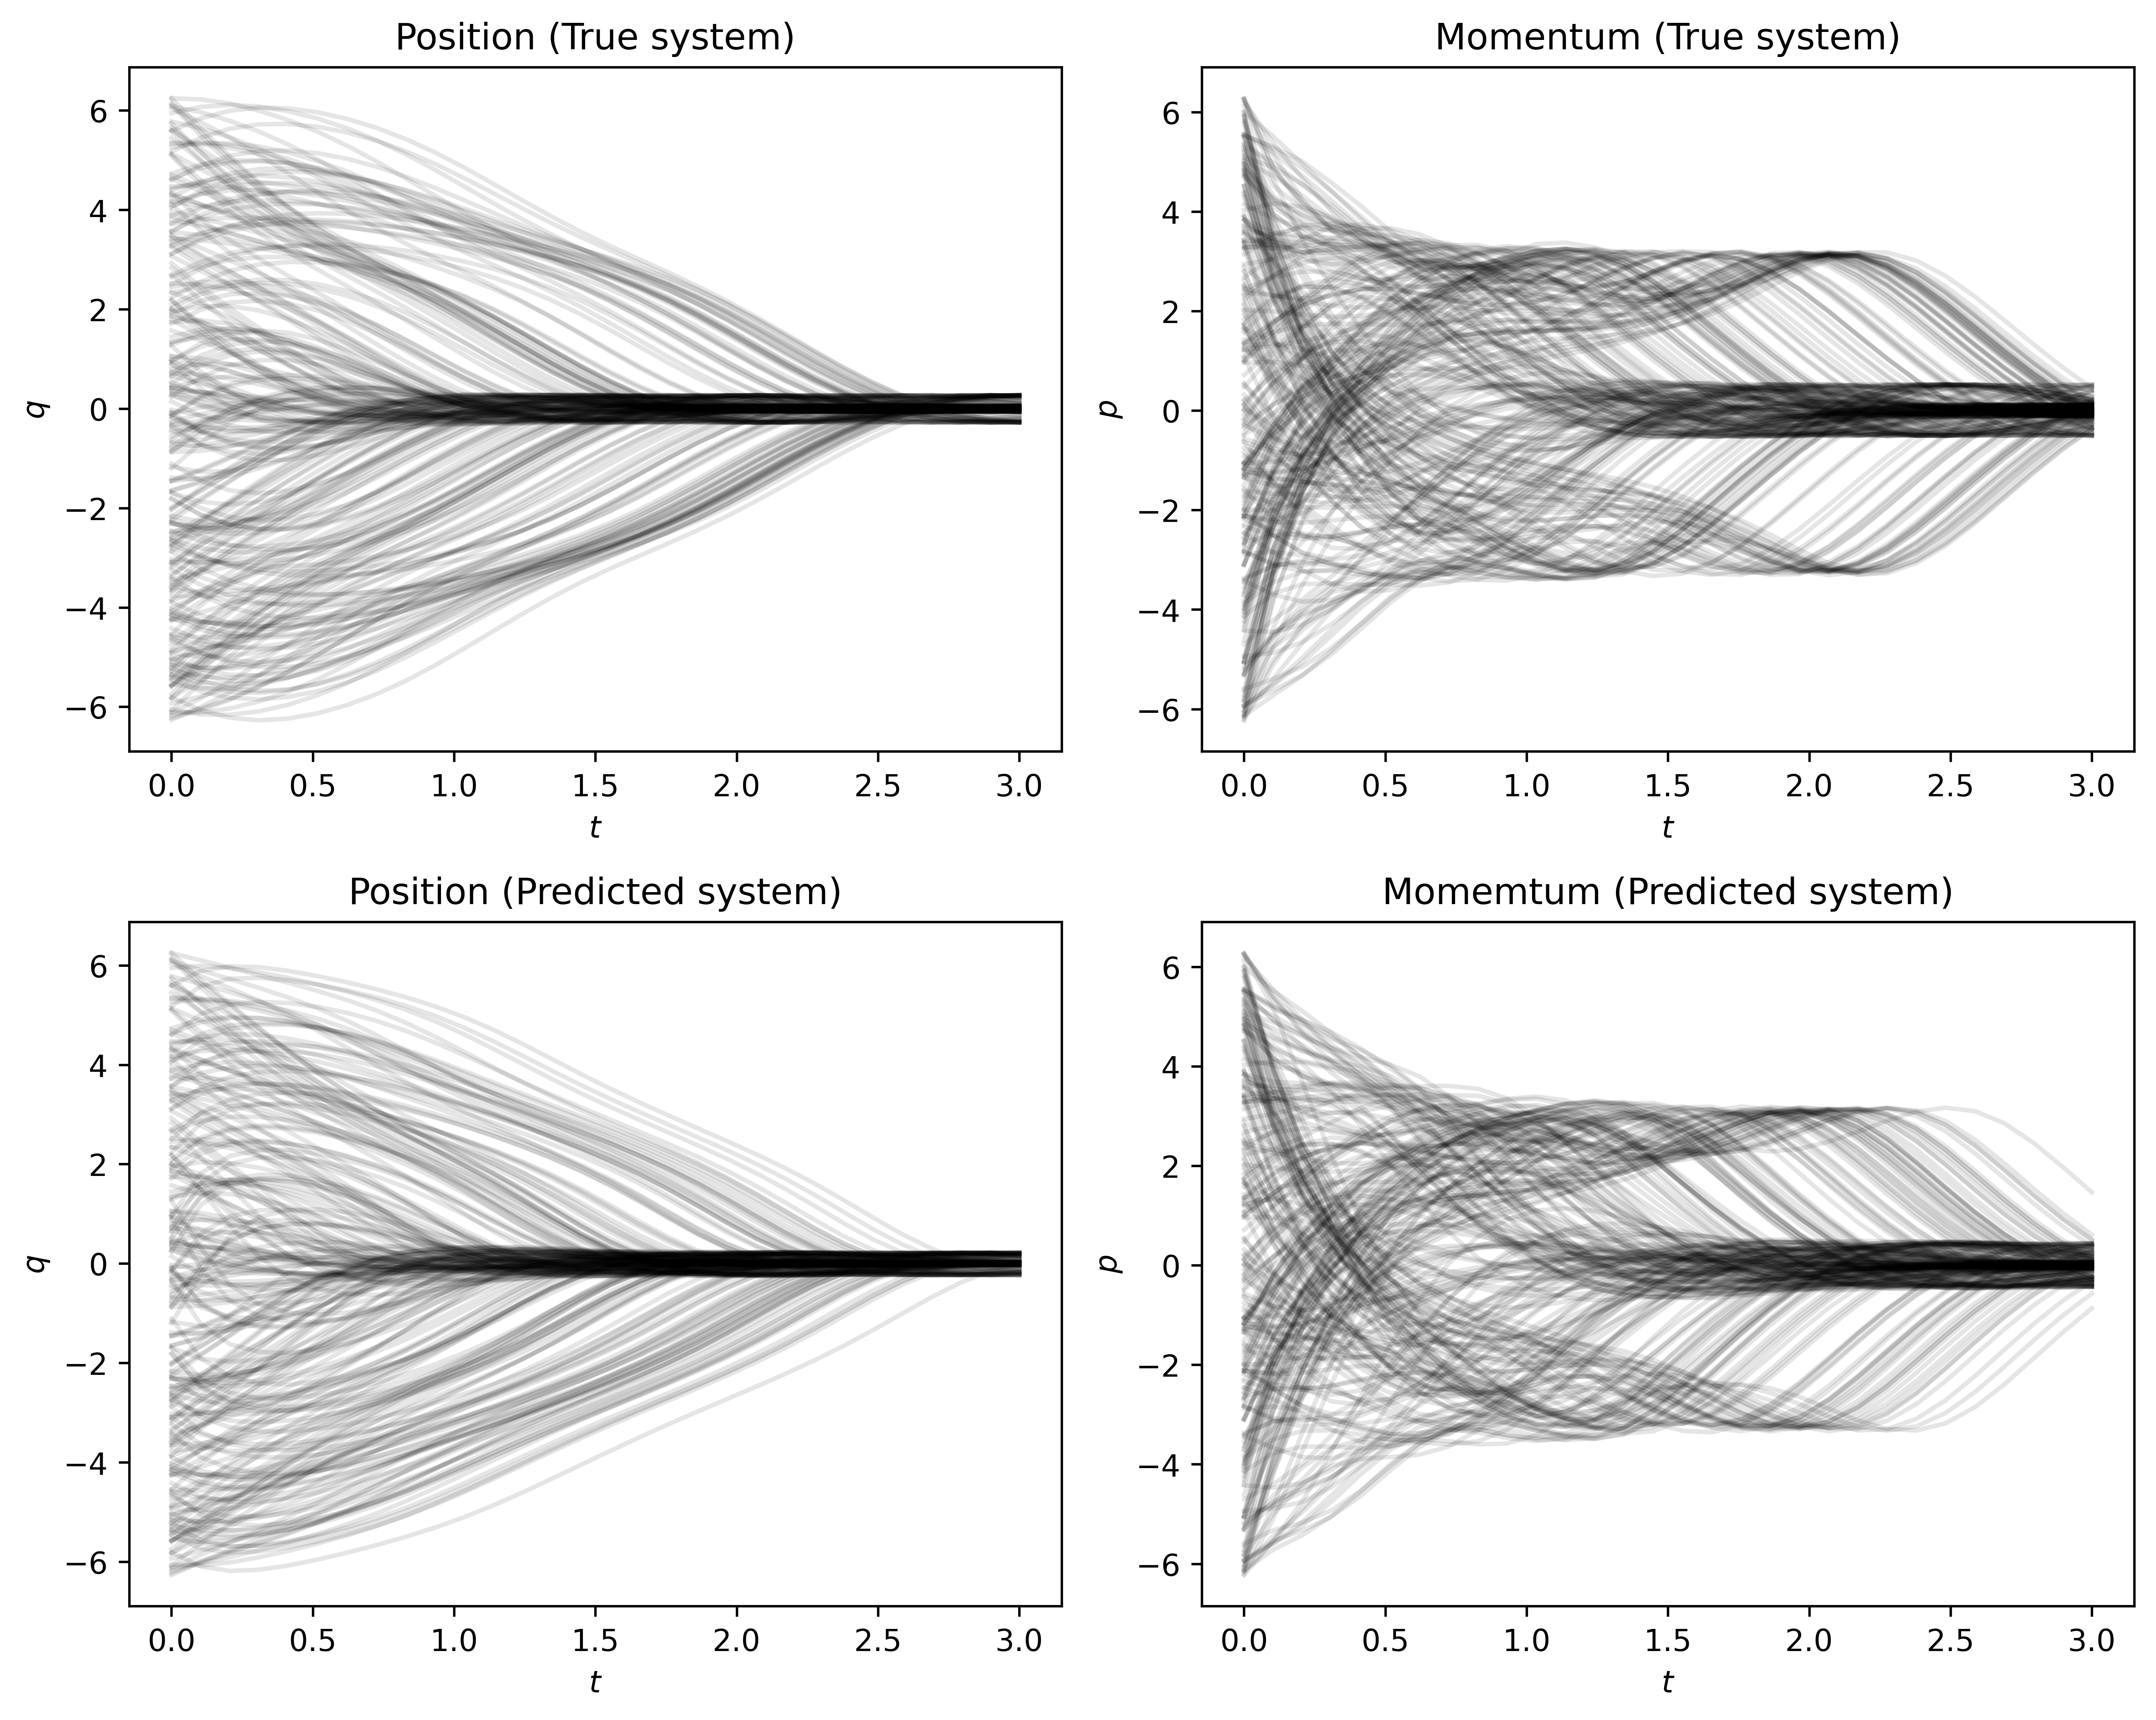

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=600)
ax[0, 0].set_xlabel(r"$t$") ; ax[0, 0].set_ylabel(r"$q$")
ax[1, 0].set_xlabel(r"$t$") ; ax[1, 0].set_ylabel(r"$q$")
ax[0, 1].set_xlabel(r"$t$") ; ax[0, 1].set_ylabel(r"$p$")
ax[1, 1].set_xlabel(r"$t$") ; ax[1, 1].set_ylabel(r"$p$")
ax[0, 0].set_title("Position (True system)")
ax[0, 1].set_title("Momentum (True system)")
ax[1, 0].set_title("Position (Predicted system)")
ax[1, 1].set_title("Momemtum (Predicted system)")

for i in range(n_ic):
    ax[0, 0].plot(t_span, traj_true_system[:,i,0], 'k', alpha=.1)
    ax[0, 1].plot(t_span, traj_true_system[:,i,1], 'k', alpha=.1)
    ax[1, 0].plot(t_span, traj_pred_system[:,i,0], 'k', alpha=.1)
    ax[1, 1].plot(t_span, traj_pred_system[:,i,1], 'k', alpha=.1) 
plt.tight_layout()

## Hamiltonian vector field

Text(0, 0.5, '$p$')

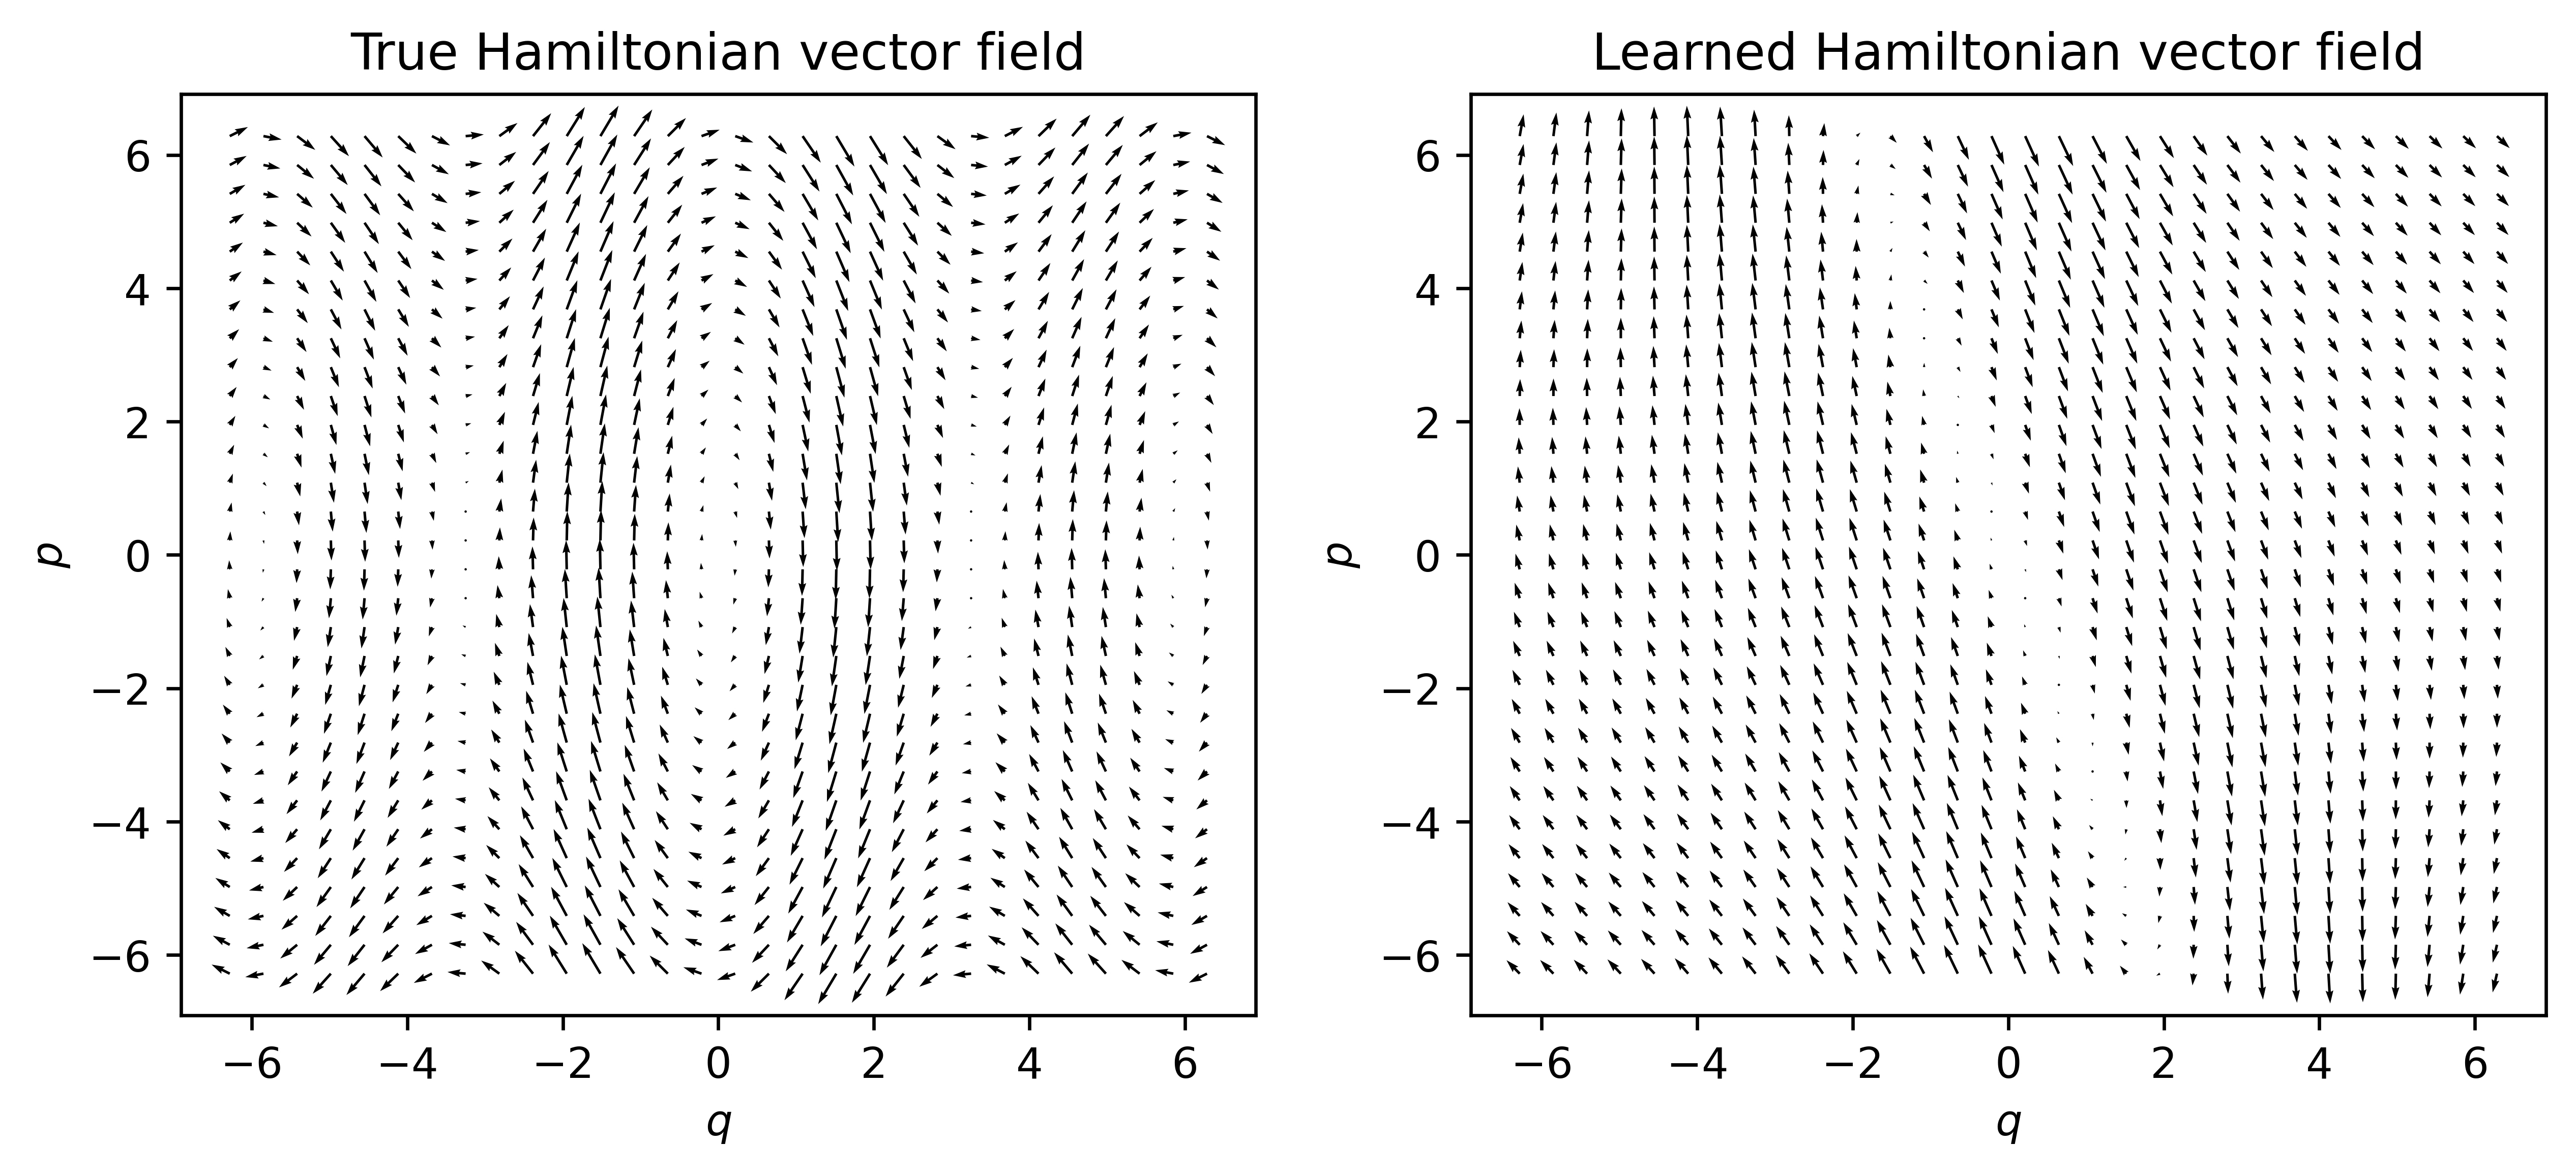

In [54]:
n_grid = 30
q_grid, p_grid = torch.linspace(-2*pi, 2*pi, n_grid), torch.linspace(-2*pi, 2*pi, n_grid)
Q, P = torch.meshgrid(q_grid, p_grid) ; z = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], 1)
z.requires_grad_(True)
learned_H = learner.model.f.H(z)
learned_dH = torch.autograd.grad(learned_H.sum(), z, create_graph=False)[0]
learned_JdH = J(learned_dH[..., None]).squeeze(2)
z.requires_grad_(False)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=600)
# true Hamiltonian vector field
ax[0].quiver(
    Q, P,
    z[:, 1].reshape(n_grid, n_grid) / 1.0,
    (-0.5 * z[:, 0] - 9.81 * torch.sin(z[:, 0]) / 1.0).reshape(n_grid, n_grid),
)
# learned Hamiltonian vector field
ax[1].quiver(Q, P, learned_dH[:,1].reshape(n_grid, n_grid), -learned_dH[:, 0].reshape(n_grid, n_grid))

ax[0].set_title("True Hamiltonian vector field")
ax[0].set_xlabel(r"$q$")
ax[0].set_ylabel(r"$p$")
ax[1].set_title("Learned Hamiltonian vector field")
ax[1].set_xlabel(r"$q$")
ax[1].set_ylabel(r"$p$")